In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap
from pixell import enplot

import data.kfilter.kfilter_share as steve

In [3]:
# from run.py
kx = 90
ky = 50
kx_apo = 0
ky_apo = 0
unpixwin = 0 # we will avoid this for now, should only matter for small scales?
d_th = 1/120.

In [4]:
sy, sx = 2000, 3000

(2000, 3000) car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[1500,1000]}


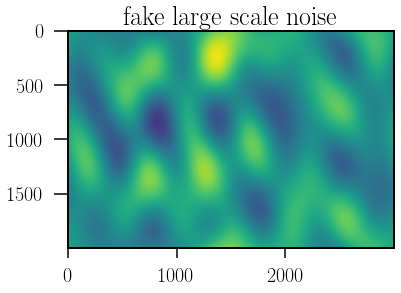

In [5]:
shape,wcs = enmap.geometry(shape=(sy,sx),
                           res=np.deg2rad(d_th),pos=(0,0))

# generate large scale noise
ps = ells = np.arange(0,4000,1)
ps = np.ones_like(ells)
rand_map = enmap.rand_map(shape,wcs, cov=ps[None,None])

kmap = enmap.fft(rand_map)
ly, lx = enmap.lmap(kmap.shape, kmap.wcs)
kmap[ np.abs(lx) > kx ] = 0.0
kmap[ np.abs(ly) > ky ] = 0.0
test_map = enmap.ifft(kmap).real

plt.title('fake large scale noise')
plt.imshow(test_map, vmin=-80, vmax=80)

print(test_map.shape, test_map.wcs)

Let's take a look at the k-space properties by converting back (also make sure we can indeed convert back!).

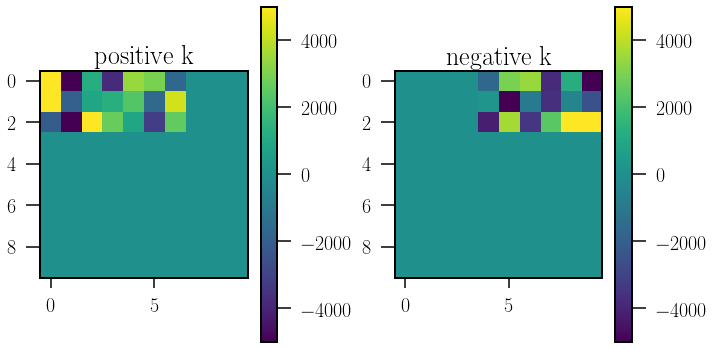

In [6]:
test_map_k = enmap.fft(test_map).real

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('positive k')
im0 = axes[0].imshow( test_map_k[0:10, 0:10].real, vmin=-5000, vmax=5000 )
fig.colorbar(im0, ax=axes[0])
axes[1].set_title('negative k')
im1 = axes[1].imshow( test_map_k[0:10, -10:].real, vmin=-5000, vmax=5000 )
fig.colorbar(im1, ax=axes[1])
plt.tight_layout()

The function definition here is

```python
def get_map_kx_ky_filtered_pyfftw(m,d_th,kx_cut,kx_cut_apo,ky_cut,ky_cut_apo,unpixwin=0,zero_pad=False):
    """ given input m (I,Q,U) apply a 2d fourier mask with ky_cut and apodization over ky_cut_apo, then return the filtered map
    uses pyfftw for fft's
    """
```

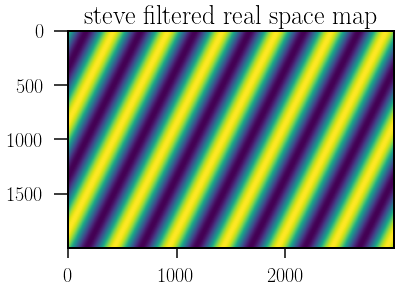

In [7]:
filtered = enmap.samewcs(
    steve.get_map_kx_ky_filtered_pyfftw(m=test_map,
                                    d_th=d_th,
                                    kx_cut=kx,kx_cut_apo=kx_apo,
                                    ky_cut=ky,ky_cut_apo=ky_apo,
                                    unpixwin=unpixwin, zero_pad=False),
    test_map)

plt.title('steve filtered real space map')
plt.imshow(filtered)

# Deliberately Tee It Up

What if we include no power at the largest positive wavenumber?

In [8]:
print( "cut kx:", np.unique( lx[np.abs(lx) < kx]) )
print( "cut ky:", np.unique( ly[np.abs(ly) < ky]) )

cut kx: [-86.70332815 -72.25277346 -57.80221877 -43.35166407 -28.90110938
 -14.45055469   0.          14.45055469  28.90110938  43.35166407
  57.80221877  72.25277346  86.70332815]
cut ky: [-43.2 -21.6   0.   21.6  43.2]


(2000, 3000) car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[1500,1000]}


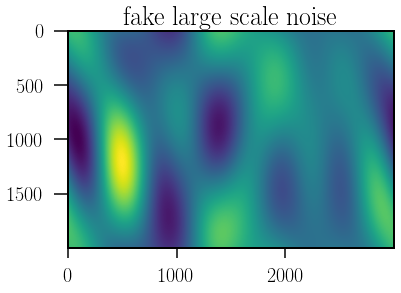

In [9]:
shape,wcs = enmap.geometry(shape=(sy,sx),
                           res=np.deg2rad(d_th),pos=(0,0))

# generate large scale noise
ps = ells = np.arange(0,4000,1)
ps = np.ones_like(ells)
rand_map = enmap.rand_map(shape,wcs, cov=ps[None,None])

kmap = enmap.fft(rand_map)
ly, lx = enmap.lmap(kmap.shape, kmap.wcs)
kmap[ np.abs(lx) > kx ] = 0.0
kmap[ np.abs(ly) > ky ] = 0.0

# NOW ALSO CUT THE BIGGEST POSITIVE WAVENUMBER =====================
kmap[ np.abs(lx) > 86 ] = 0.0
kmap[ np.abs(ly) > 40 ] = 0.0
# =============================================================

test_map = enmap.ifft(kmap).real
plt.title('fake large scale noise')
plt.imshow(test_map)
print(test_map.shape, test_map.wcs)

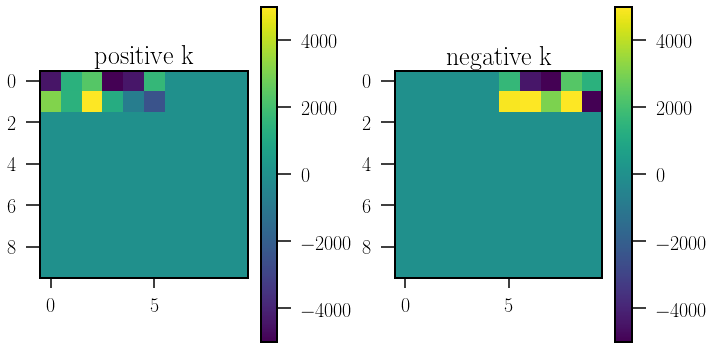

In [10]:
test_map_k = enmap.fft(test_map).real

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('positive k')
im0 = axes[0].imshow( test_map_k[0:10, 0:10].real, vmin=-5000, vmax=5000 )
fig.colorbar(im0, ax=axes[0])
axes[1].set_title('negative k')
im1 = axes[1].imshow( test_map_k[0:10, -10:].real, vmin=-5000, vmax=5000 )
fig.colorbar(im1, ax=axes[1])
plt.tight_layout()

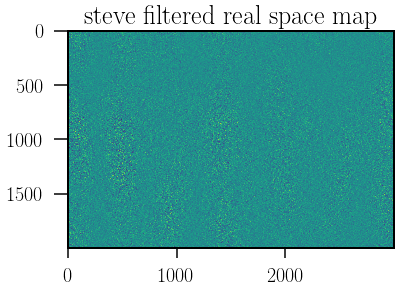

In [11]:
filtered = enmap.samewcs(
    steve.get_map_kx_ky_filtered_pyfftw(m=test_map,
                                    d_th=d_th,
                                    kx_cut=kx,kx_cut_apo=kx_apo,
                                    ky_cut=ky,ky_cut_apo=ky_apo,
                                    unpixwin=unpixwin, zero_pad=False),
    test_map)

plt.title('steve filtered real space map')
plt.imshow(filtered)

So Steve's script does appear to filter the modes except for the largest positive wavenumber.

# DIY

Now let's try it with pixell functions.

In [12]:
def filter_map(m, kx, ky):
    k_r0 = enmap.fft(m)
    ly, lx = enmap.lmap(k_r0.shape, k_r0.wcs)
    k_r0[ (np.abs(lx) <= kx ) ] = 0.0
    k_r0[ (np.abs(ly) <= ky ) ] = 0.0
    r0_diy = enmap.ifft(k_r0)
    return r0_diy.real

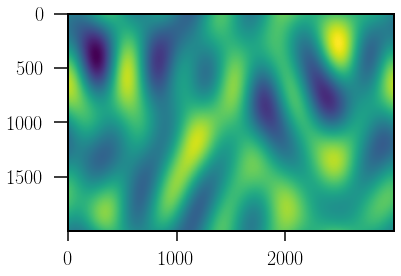

In [13]:
shape,wcs = enmap.geometry(shape=(sy,sx),
                           res=np.deg2rad(d_th),pos=(0,0))

# generate large scale noise
ps = ells = np.arange(0,4000,1)
ps = np.ones_like(ells)
rand_map = enmap.rand_map(shape,wcs, cov=ps[None,None])

kmap = enmap.fft(rand_map)
ly, lx = enmap.lmap(kmap.shape, kmap.wcs)
kmap[ np.abs(lx) > kx ] = 0.0
kmap[ np.abs(ly) > ky ] = 0.0
test_map = enmap.ifft(kmap).real
plt.imshow(test_map)

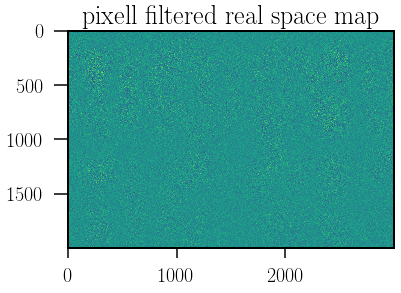

In [14]:
diy_filtered = filter_map(test_map, kx, ky)

plt.title('pixell filtered real space map')
plt.imshow(diy_filtered)